# Convo AutoEncoder

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import keras
from keras import layers, models
from keras.layers import Dense

In [6]:
authentication_data = pd.read_csv('https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/raw/main/Data/Authentication%20data.gz', compression='gzip', index_col = 0)

/Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Otherwise use sorting


In [12]:
rt_usernames = list(pd.read_csv('https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/raw/main/Data/AuthUserNames.txt', header=None)[0])


In [7]:
# splits a dataframe into n chunks
def split_dataframe(df,n): 
    chunks = list()
    chunk_size = int(np.round(df.shape[0]/n))
    num_chunks = n
    for i in range(num_chunks):
        if i != num_chunks-1:
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
        else:
            chunks.append(df[i*chunk_size:])
    return chunks

In [9]:
auth_index_list = authentication_data.index.tolist()
auth_start_days = [i for i, e in enumerate(auth_index_list) if e == 0]
auth_start_days.append(len(authentication_data))

def auth_type_un_df(user,n):
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n

    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type').size()
                auth_type_df[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())

    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    return auth_type_df

In [74]:
df = auth_type_un_df(rt_usernames[0],24)
rank_2 =  np.array(df)
rank_3 = tf.stack([rank_2[i:i+23] for i in np.arange(0,len(rank_2)-1,24)])

npad = ((0, 0), (1, 0), (1, 0))    
rank_3 = np.pad(rank_3, pad_width=npad, mode='constant', constant_values=0)


In [75]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from keras.models import Model


input_img = Input(shape=(24, 14, 1)) 

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

convo_autoencoder = Model(input_img, decoded)
convo_autoencoder.compile(metrics=['accuracy'], optimizer='adam', loss='mse')

In [76]:
convo_autoencoder.fit(rank_3[:57], rank_3[:57], epochs=10, batch_size=256)

Epoch 1/10
1/1 [==============================] - 1s 683ms/step - loss: 0.2572 - accuracy: 0.7162
Epoch 2/10
1/1 [==============================] - 0s 34ms/step - loss: 0.2550 - accuracy: 0.7435
Epoch 3/10
1/1 [==============================] - 0s 51ms/step - loss: 0.2530 - accuracy: 0.7792
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 0.2508 - accuracy: 0.8272
Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 0.2487 - accuracy: 0.8664
Epoch 6/10
1/1 [==============================] - 0s 46ms/step - loss: 0.2466 - accuracy: 0.9019
Epoch 7/10
1/1 [==============================] - 0s 49ms/step - loss: 0.2444 - accuracy: 0.9220
Epoch 8/10
1/1 [==============================] - 0s 46ms/step - loss: 0.2423 - accuracy: 0.9383
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 0.2402 - accuracy: 0.9530
Epoch 10/10
1/1 [==============================] - 0s 33ms/step - loss: 0.2380 - accuracy: 0.9629


In [77]:
convo_autoencoder.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 24, 14, 1)]       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 24, 14, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 12, 7, 32)         0         
_________________________________________________________________
up_sampling2d_21 (UpSampling (None, 24, 14, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 24, 14, 1)         289       
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [78]:
reconstruction = convo_autoencoder.predict(np.array(rank_3[79]).reshape(1,24,14))

In [80]:
convo_error_list = []
for i in range (33):
    convo_reconstruction = convo_autoencoder.predict(np.array(rank_3[57+i]).reshape(1,24,14))
    convo_reconstruction = convo_reconstruction.reshape(1, 24, 14)
    convo_error = np.mean(np.power(np.array(rank_3[57+i]).reshape(1,24,14)-convo_reconstruction, 2))
    convo_error_list.append(convo_error)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f81474ea430>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8148250730>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f81471addc0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8148250c40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f81477a9970>],
 'means': []}

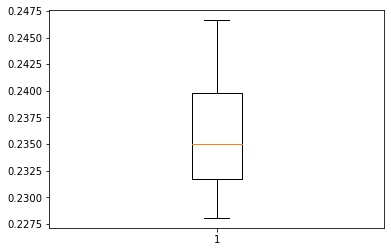

In [81]:
plt.boxplot(convo_error_list)

# Regular AutoEncoder

In [88]:
input_img = Input(shape=(24, 14, 1)) 

encoded = layers.Dense(32, activation='relu')(input_img)
encoded = layers.Dense(16, activation='relu')(encoded)
encoded = layers.Dense(8, activation='relu')(encoded)

decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(32, activation='relu')(decoded)
decoded = layers.Dense(32, activation='softmax')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(metrics=['accuracy'], optimizer='adam', loss='mse')

In [89]:
autoencoder.fit(rank_3[:57], rank_3[:57], epochs=10, batch_size=256)

Epoch 1/10


ValueError: in user code:

    /Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/keras/engine/training.py:830 train_function  *
        return step_function(self, iterator)
    /Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/keras/engine/training.py:813 run_step  *
        outputs = model.train_step(data)
    /Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/keras/engine/training.py:771 train_step  *
        loss = self.compiled_loss(
    /Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/keras/engine/compile_utils.py:201 __call__  *
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/keras/losses.py:142 __call__  *
        losses = call_fn(y_true, y_pred)
    /Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/keras/losses.py:246 call  *
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/keras/losses.py:1202 mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
    /Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:10422 squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3557 _create_op_internal
        ret = Operation(
    /Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 14 and 24 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](model_16/dense_29/Softmax, IteratorGetNext:1)' with input shapes: [?,24,14,32], [?,24,14].


In [ ]:
error_list = []
for i in range (33):
    reconstruction = autoencoder.predict(np.array(rank_3[57+i]).reshape(1,24,14))
    reconstruction = reconstruction.reshape(1, 24, 14)
    error = np.mean(np.power(np.array(rank_3[57+i]).reshape(1,24,14)-reconstruction, 2))
    error_list.append(error)

In [ ]:
plt.boxplot(error_list)